# Analysis of Policy Excerpt Sub-labels

Researchers expressed interest in focussing on the sub-labels of policy. These sub-labels are:

    ['OtherAdv',
     'VictimAdv',
     'Guns',
     'InfoSharing',
     'MentalHealth',
     'Other',
     'Practice',
     'Immigration']
     
The following notebook will focus on only the excerpts that have the label policy, and analysis the composition of the sub labels of this topic. 

## Loading and Formatting Data

In [7]:
from tensorflow import keras
import os
import re
import nltk
from nltk import sent_tokenize
import pandas as pd
nltk.download('punkt')
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/andreapagotto/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [13]:
filepath = 'data/'
filenames = [filepath+filename for filename in os.listdir('data/') if 'xlsx' in filename]
print(filenames)

DATA_COLUMN = 'excerpt'
LABEL_COLUMN = 'label'
label_list = [0, 1]
max_sent = 5
label = 'policy'
# We'll set sequences to be at most 128 tokens long.
MAX_SEQ_LENGTH = 128

['data/Vegas - All Excerpts - 7_15_2019.xlsx', 'data/Charleston - All Excerpts - 7_15_2019.xlsx', 'data/Marysville - All Excerpts - Final - 1_2_2019.xlsx', 'data/Isla Vista - All Excerpts - 1_2_2019.xlsx', 'data/Orlando - All Excerpts - 7_15_2019.xlsx', 'data/~$Isla Vista - All Excerpts - 1_2_2019.xlsx', 'data/San Bernardino - All Excerpts - 7_15_2019.xlsx', 'data/Newtown - All Excerpts - 1-2-2019.xlsx']


In [15]:
train_list = []
test_list = []
for file_name in filenames:
    try:
        data = pd.read_excel(file_name, sheet_name='Dedoose Excerpts Export')
        data = data.dropna(axis=0)
        print(file_name)

        # get relevant columns:
        label_cols = [l for l in data.columns if label in l.lower()]
        excerpt_col = [l for l in data.columns if DATA_COLUMN in l.lower()][0]
        data_subcols = data.loc[:, label_cols+[excerpt_col]]

        for colname in label_cols:
            data_subcols = data_subcols.astype({colname: int})
            id0 = [val not in [0, 1] for val in data_subcols.loc[:, colname]]
            data_subcols.loc[id0, colname] = 0

        #print(data_subcols.shape)
        print(label_cols)

        # filter out rows that do not have any policy subtype label
        label_ids = data_subcols.loc[:, label_cols].sum(axis=1) > 1 
        df_label = data_subcols.loc[label_ids,:]
        #print(df_label.shape)

        # filter out long excerpts

        short_ex_ids = [len(sent_tokenize(sent))>max_sent for sent in df_label.loc[:, excerpt_col]]
        df_label_short = df_label.loc[short_ex_ids, :]
        print(df_label_short.shape)

        # split into train and test dfs
        train, test = train_test_split(df_label_short, test_size=0.25, random_state=42)
        #print(train.shape)
        #print(test.shape)
        train_list.append(train)
        test_list.append(test)
    except:
        print("could not open:"+file_name)

data/Vegas - All Excerpts - 7_15_2019.xlsx
['Code: Policy Applied', 'Code: Policy\\Advocacy by others Applied', 'Code: Policy\\Advocacy by victims families Applied', 'Code: Policy\\Guns Applied', 'Code: Policy\\Immigration Applied', 'Code: Policy\\Information Sharing Applied', 'Code: Policy\\Mental Health Applied', 'Code: Policy\\Other Applied', 'Code: Policy\\Practice Applied']
(52, 10)
data/Charleston - All Excerpts - 7_15_2019.xlsx
['Code: Policy Applied', 'Code: Policy\\Advocacy by others Applied', 'Code: Policy\\Advocacy by victims families Applied', 'Code: Policy\\Guns Applied', 'Code: Policy\\Immigration Applied', 'Code: Policy\\Information Sharing Applied', 'Code: Policy\\Mental Health Applied', 'Code: Policy\\Other Applied', 'Code: Policy\\Practice Applied']
(59, 10)
data/Marysville - All Excerpts - Final - 1_2_2019.xlsx
['POLICY', 'POLICY_Guns', 'POLICY_InfoSharing', 'POLICY_MentalHealth', 'POLICY_Other', 'POLICY_VictimAdv', 'POLICY_OtherAdv', 'POLICY_Practice']
(16, 9)
data/

In [16]:
# transform columns for all data frames to be the same
col_dict = {
    'OtherAdv': ['POLICY_OtherAdv', 'Code: Policy\Advocacy by others Applied'],
    'VictimAdv': ['POLICY_VictimAdv', 'Code: Policy\Advocacy by victims families Applied'],
    'Guns': [ 'POLICY_Guns', 'Code: Policy\Guns Applied'],
    'InfoSharing': ['POLICY_InfoSharing', 'Code: Policy\Information Sharing Applied'],
    'MentalHealth': ['POLICY_MentalHealth', 'Code: Policy\Mental Health Applied'],
    'Other': ['POLICY_Other', 'Code: Policy\Other Applied'],
    'Practice': ['POLICY_Practice', 'Code: Policy\Practice Applied'],
    'Immigration': ['Code: Policy\Immigration Applied']
}

LABEL_COLUMNS = list(col_dict.keys())

In [17]:
def merge_dfs(df_list):
    merged_df = pd.DataFrame(columns = list(col_dict.keys())+[DATA_COLUMN])

    for df in df_list:
        df_renamed = pd.DataFrame(columns = col_dict.keys(), index = df.index)
        print(df.shape)

        #renamed ex col
        df_renamed[DATA_COLUMN] = df.loc[:,[l for l in df.columns if DATA_COLUMN in l.lower()][0]]

        # make each dict in the list to have the columns in col_dict
        for new_colname in col_dict.keys():
            #check if df has subtype:
            col = [colname for colname in df.columns if colname in col_dict[new_colname]]
            if len(col) ==0:
                df_renamed[new_colname] = 0
            else:
                df_renamed[new_colname] = df.loc[:, col]
        merged_df = merged_df.append(df_renamed, ignore_index=True)
    print(merged_df.shape)
    return merged_df

test_merged = merge_dfs(test_list)
train_merged = merge_dfs(train_list)
train_merged.loc[:, col_dict.keys()].head()

(13, 10)
(15, 10)
(4, 9)
(68, 9)
(13, 10)
(14, 10)
(140, 9)
(267, 9)
(39, 10)
(44, 10)
(12, 9)
(204, 9)
(37, 10)
(42, 10)
(420, 9)
(798, 9)


,OtherAdv,VictimAdv,Guns,InfoSharing,MentalHealth,Other,Practice,Immigration
0,1,0,1,0,0,0,0,0
1,0,0,1,0,0,0,0,0
2,1,0,1,0,0,0,0,0
3,1,0,1,0,0,0,0,0
4,1,0,1,0,0,0,0,0


## Individual Sub-Label Counts

Text(0.5, 1.0, 'Counts of Each Policy Sub-type')

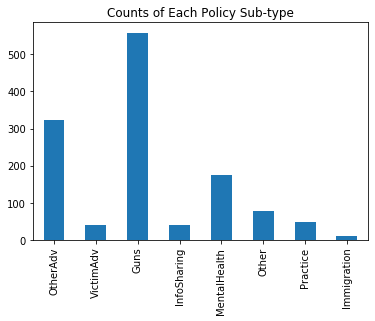

In [28]:
train_merged.loc[:, LABEL_COLUMNS].sum().plot.bar()
plt.title("Counts of Each Policy Sub-type")

Text(0.5, 1.0, 'Counts of Each Policy Sub-type')

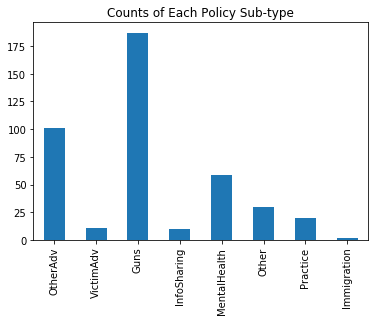

In [29]:
test_merged.loc[:, LABEL_COLUMNS].sum(axis=0).plot.bar()
plt.title("Counts of Each Policy Sub-type")

Text(0.5, 1.0, 'Counts of Number of Co-occuring Labels per Excerpt')

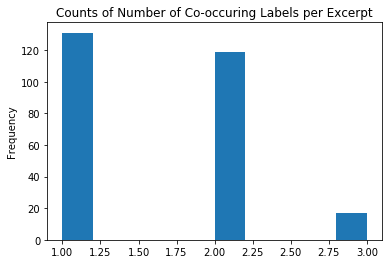

In [85]:
test_merged.loc[:, LABEL_COLUMNS].sum(axis=1).plot.hist()
plt.title("Counts of Number of Co-occuring Labels per Excerpt")

## Co-Occuring Label Counts

This shows that most excerpts have one or two labels. Next we can analyze which two labels co-occur most frequently.

In [80]:
occ2_labs = []
for row in train_merged.loc[:, LABEL_COLUMNS].iterrows():
    labs = row[1] == 1
    if sum(labs) == 2:
        #print(list(row[1].loc[labs.values].index))
        occ2_labs.append('+'.join(list(row[1].loc[labs.values].index)))
        
print(set(occ2_labs))

{'VictimAdv+Other', 'Other+Practice', 'Guns+InfoSharing', 'OtherAdv+Guns', 'OtherAdv+InfoSharing', 'VictimAdv+InfoSharing', 'OtherAdv+Practice', 'Guns+Other', 'OtherAdv+Immigration', 'VictimAdv+Immigration', 'Guns+MentalHealth', 'VictimAdv+Guns', 'OtherAdv+MentalHealth', 'MentalHealth+Practice', 'OtherAdv+Other', 'InfoSharing+MentalHealth', 'MentalHealth+Other'}


Text(0.5, 1.0, 'Co-occuring label counts')

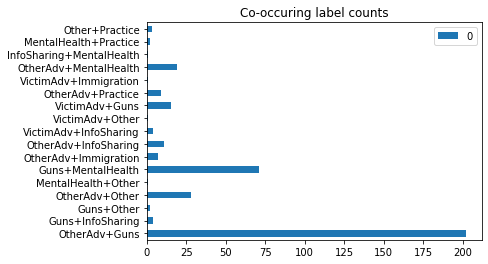

In [81]:
from collections import Counter
occ2_counts = Counter(occ2_labs)
df2 = pd.DataFrame.from_dict(occ2_counts, orient='index')
df2.plot.barh()
plt.title("Co-occuring label counts")

In [82]:
occ3_labs = []
for row in train_merged.loc[:, LABEL_COLUMNS].iterrows():
    labs = row[1] == 1
    if sum(labs) == 3:
        #print(list(row[1].loc[labs.values].index))
        occ3_labs.append('+'.join(list(row[1].loc[labs.values].index)))
        
print(set(occ3_labs))

{'VictimAdv+MentalHealth+Practice', 'OtherAdv+VictimAdv+Guns', 'OtherAdv+VictimAdv+InfoSharing', 'OtherAdv+Guns+Other', 'OtherAdv+MentalHealth+Practice', 'OtherAdv+Guns+InfoSharing', 'Guns+MentalHealth+Practice', 'Guns+MentalHealth+Other', 'OtherAdv+Guns+MentalHealth'}


Text(0.5, 1.0, 'Co-occuring label counts')

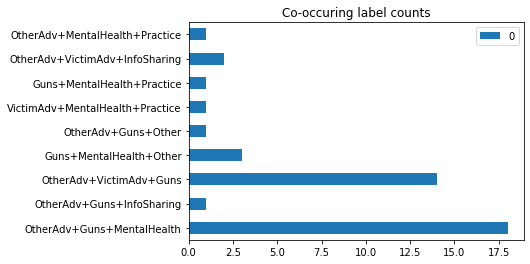

In [83]:
occ3_counts = Counter(occ3_labs)
df3 = pd.DataFrame.from_dict(occ3_counts, orient='index')
df3.plot.barh()
plt.title("Co-occuring label counts")

## Top Occurring Subset of Labels 1-3

In [96]:
labs_counts = []
for row in train_merged.loc[:, LABEL_COLUMNS].iterrows():
    labs = row[1] == 1
    if sum(labs) > 0: # any labl
        labs_counts.append('+'.join(list(row[1].loc[labs.values].index)))
        
test_labs_counts = []
for row in test_merged.loc[:, LABEL_COLUMNS].iterrows():
    labs = row[1] == 1
    if sum(labs) > 0: # any labl
        test_labs_counts.append('+'.join(list(row[1].loc[labs.values].index)))

<Figure size 1440x1440 with 0 Axes>

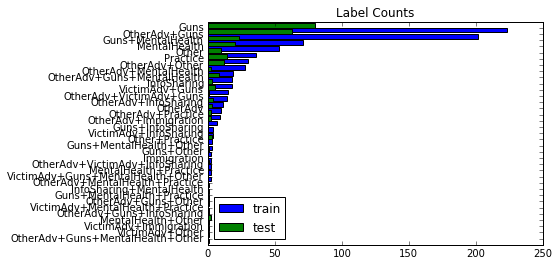

In [134]:
import seaborn as sns
plt.style.use('classic')
#%matplotlib notebook
#%matplotlib ipympl
%matplotlib inline

plt.figure(figsize = (20, 20))

occ_counts = Counter(labs_counts)
df = pd.DataFrame.from_dict(occ_counts, orient='index').sort_values(by = 0)
df.columns = ["train"]

test_occ_counts = Counter(test_labs_counts)
tdf = pd.DataFrame.from_dict(test_occ_counts, orient='index')
df['test'] = tdf

df.plot.barh(width = 1.5)
plt.title("Label Counts")
plt.savefig('labelcounts.png')
plt.show()


In [136]:
df['combined_labels'] = list(df.index)
df

,train,test,combined_labels
OtherAdv+Guns+MentalHealth+Other,1,NaN,OtherAdv+Guns+MentalHealth+Other
VictimAdv+Other,1,NaN,VictimAdv+Other
VictimAdv+Immigration,1,NaN,VictimAdv+Immigration
MentalHealth+Other,1,2.0,MentalHealth+Other
OtherAdv+Guns+InfoSharing,1,1.0,OtherAdv+Guns+InfoSharing
VictimAdv+MentalHealth+Practice,1,NaN,VictimAdv+MentalHealth+Practice
OtherAdv+Guns+Other,1,1.0,OtherAdv+Guns+Other
Guns+MentalHealth+Practice,1,NaN,Guns+MentalHealth+Practice
InfoSharing+MentalHealth,1,NaN,InfoSharing+MentalHealth
OtherAdv+MentalHealth+Practice,1,NaN,OtherAdv+MentalHealth+Practice


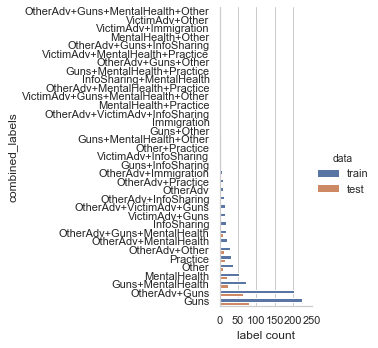

In [145]:
sns.set(style="whitegrid")
snsdf = pd.melt(df, id_vars="combined_labels", var_name="data", value_name="label count")
#sns.factorplot(x='label count', y='combined_labels', hue='data', data=snsdf, kind='bar')
sns.catplot(x='label count', y='combined_labels', hue='data', data=snsdf, kind='bar')